In [1]:
%load_ext autoreload
%autoreload 2
import eval_models
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['font.size'] = 25

In [2]:
X_art_train,X_art_test,y_art_train,y_art_test=eval_models.get_train_test("artificial")

# PART 1 EXPERIMENTS

## No standarization at all

In [3]:
RF = RandomForestClassifier(n_jobs=-1, max_depth=6)
feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
feat_select.fit(X_art_train.values,y_art_train)
X_art_train_boruta=X_art_train.iloc[:,feat_select.support_]
X_art_test_boruta=X_art_test.iloc[:,feat_select.support_]

In [4]:
noscaling_res=eval_models.get_models_ba(X_art_train_boruta,
                              X_art_test_boruta,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.624
RandomForestClassifier 0.888
AdaBoostClassifier 0.634
LGBMClassifier 0.878
XGBClassifier 0.87
22  features in the dataset


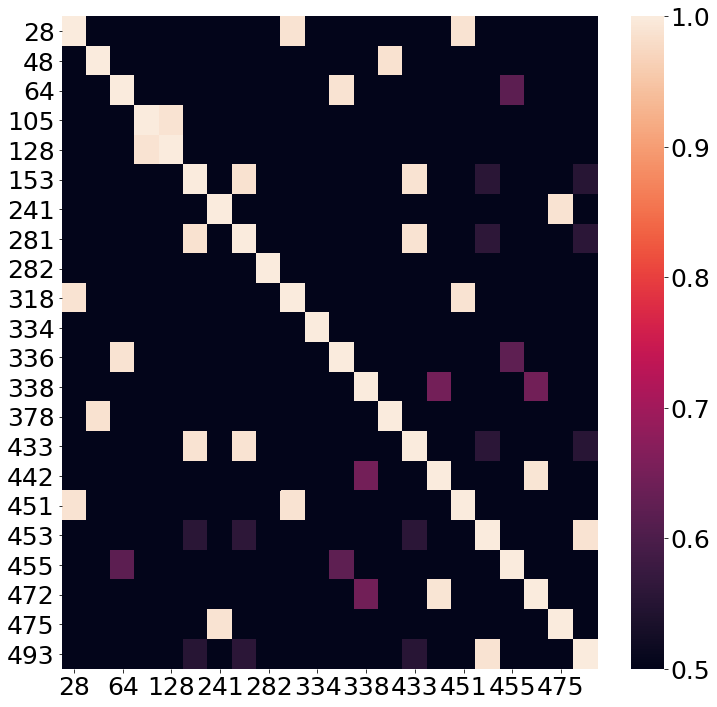

In [5]:
plt.figure(figsize=(12,12))
corr = X_art_train_boruta.corr()
sns.heatmap(corr,vmin=0.5,vmax=1)
plt.show()

In [6]:
X_train_no_corr=eval_models.delete_corr(X_art_train_boruta)

In [7]:
noscaling_res_cor=eval_models.get_models_ba(X_train_no_corr,
                              X_art_test_boruta,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.628
RandomForestClassifier 0.884
AdaBoostClassifier 0.628
LGBMClassifier 0.888
XGBClassifier 0.888
12  features in the dataset


## Standarization after Boruta (not really expecting it to work)

In [8]:
X_art_train_boruta_sc,X_art_test_boruta_sc=eval_models.standarize(X_art_train_boruta,X_art_test_boruta)

In [9]:
X_train_no_corr2=eval_models.delete_corr(X_art_train_boruta_sc)

In [10]:
noscaling_res_cor=eval_models.get_models_ba(X_train_no_corr2,
                              X_art_test_boruta_sc,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.634
RandomForestClassifier 0.882
AdaBoostClassifier 0.628
LGBMClassifier 0.882
XGBClassifier 0.888
12  features in the dataset


## Standarization before Boruta

In [11]:
X_art_train_sc,X_art_test_sc=eval_models.standarize(X_art_train,X_art_test)

In [12]:
### (suggested max_depth between 3 and 7) podobno
RF = RandomForestClassifier(n_jobs=-1, max_depth=7)
feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
feat_select.fit(X_art_train_sc.values,y_art_train)
X_art_train_sc_boruta=X_art_train_sc.iloc[:,feat_select.support_]
X_art_test_sc_boruta=X_art_test_sc.iloc[:,feat_select.support_]

In [13]:
scaled_res=eval_models.get_models_ba(X_art_train_sc_boruta,
                              X_art_test_sc_boruta,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.636
RandomForestClassifier 0.884
AdaBoostClassifier 0.634
LGBMClassifier 0.878
XGBClassifier 0.874
20  features in the dataset


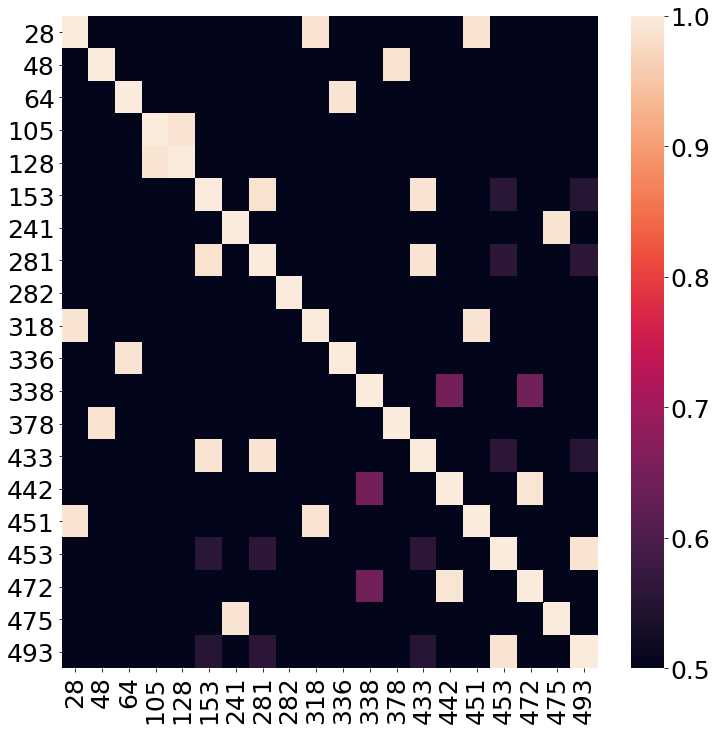

In [17]:
plt.figure(figsize=(12,12))
corr = X_art_train_sc_boruta.corr()
sns.heatmap(corr,vmin=0.5,vmax=1)
plt.show()

In [15]:
X_art_train_sc_no_corr=eval_models.delete_corr(X_art_train_sc_boruta)

In [16]:
scaled_res_cor=eval_models.get_models_ba(X_art_train_sc_no_corr,
                              X_art_test_sc_boruta,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.632
RandomForestClassifier 0.884
AdaBoostClassifier 0.62
LGBMClassifier 0.872
XGBClassifier 0.888
10  features in the dataset


## Cross validation (with standarization before Boruta)

In [ ]:
kf = KFold(n_splits=5,shuffle=True)
models_res=[]
for train_idx, val_idx in tqdm(kf.split(X_art_train)):
    X_train=X_art_train.iloc[train_idx,:]
    X_val=X_art_train.iloc[val_idx,:]
    y_train=y_art_train[train_idx]
    y_val=y_art_train[val_idx]
    
    X_train_sc,X_val_sc=eval_models.standarize(X_train,X_val)
    
    RF = RandomForestClassifier(n_jobs=-1, max_depth=6)
    feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
    feat_select.fit(X_train.values,y_train)
    
    X_train_sc_boruta=X_train_sc.iloc[:,feat_select.support_]
    X_val_sc_boruta=X_val_sc.iloc[:,feat_select.support_]
    

    with open('../data/boruta/artificial-features.csv', 'a') as f:
        np.savetxt(f, np.where(feat_select.support_), delimiter=",", fmt='%i')
    f.close()
    X_train_sc_boruta_no_corr=eval_models.delete_corr(X_train_sc_boruta)
    tmp=eval_models.get_models_ba(X_train_sc_boruta_no_corr,X_val_sc_boruta,y_train,y_val)
    models_res.append(tmp)

In [ ]:
pd.concat(models_res, ignore_index=1).groupby(by='Classifier').mean().sort_values(by="BA score")

In conclusion we could expect sth around 0.84 balanced accuracy score with 10 features.
We could use some other method to select only the 5 best ones. Nie wiem czy jest sens bo użycie 10 zamiast 5 to kara na poziomie 1 punktu procentowego

# PART 2 Final selection

Now, having run CV we will select only those variables which have been selected every time
**YOU SHOULDN'T run the CV, it has been run already, if you wish to do it anyway you should consider clearing the file 'artificial-features.csv'** where the selected features are stored

In [18]:
boruta_all_results=pd.read_csv('../data/boruta/artificial-features.csv',header=None,sep="\n")
x_times=boruta_all_results.shape[0]
boruta_all_results=boruta_all_results.iloc[:,0].str.split(',', expand=True)

In [19]:
boruta_all_array=np.array(list(filter(None, np.array(boruta_all_results).flatten()))).astype(np.int64)
unique, counts=np.unique(np.array(boruta_all_array).flatten(),return_counts=True)
columns_boruta= unique[counts>=x_times]

In [20]:
X_art_train_boruta_multiple=X_art_train.iloc[:,columns_boruta]
X_art_train_boruta_multiple.head()

,28,48,64,105,128,153,241,281,318,336,338,378,433,442,451,453,472,475,493
508,468,537,588,484,478,517,425,487,443,602,573,548,509,613,469,625,533,377,636
242,493,434,468,554,484,681,534,563,530,451,343,434,625,377,488,526,415,529,546
1024,493,497,301,755,500,433,578,448,529,278,389,516,451,440,485,453,458,612,464
782,503,434,367,612,490,445,527,452,555,327,441,409,459,471,491,460,470,521,473
677,479,504,586,454,475,596,489,533,482,584,472,524,576,434,477,489,447,475,506


Results without standarization and removing based on VIF

In [21]:
eval_models.get_models_ba(X_art_train_boruta_multiple,
                              X_art_test,
                              y_art_train,
                              y_art_test,
                          n_estimators=250
                             )

LogisticRegression 0.642
RandomForestClassifier 0.884
AdaBoostClassifier 0.622
LGBMClassifier 0.878
XGBClassifier 0.876
19  features in the dataset


,Classifier,BA score
0,LogisticRegression,0.642
1,RandomForestClassifier,0.884
2,AdaBoostClassifier,0.622
3,LGBMClassifier,0.878
4,XGBClassifier,0.876


Now we standarize both sets and remove some variables based on VIF

In [22]:
X_art_train_scaled,X_art_test_scaled=eval_models.standarize(X_art_train,X_art_test)
X_art_train_scaled_boruta_multiple=X_art_train_scaled.iloc[:,columns_boruta]

In [23]:
res_boruta_no_vif=eval_models.get_models_ba(X_art_train_scaled_boruta_multiple,
                              X_art_test_scaled,
                              y_art_train,
                              y_art_test,
                          n_estimators=250
                             )
res_boruta_no_vif['VIF']="No (19 features)"

LogisticRegression 0.638
RandomForestClassifier 0.88
AdaBoostClassifier 0.62
LGBMClassifier 0.878
XGBClassifier 0.876
19  features in the dataset


In [24]:
X_art_train_scaled_boruta_multiple_vif=eval_models.delete_multicollinear(X_art_train_scaled_boruta_multiple)

18
17
16
15
14
13
12
11
10
9
8
7
6
5
5 features left


In [25]:
res_boruta_yes_vif=eval_models.get_models_ba(X_art_train_scaled_boruta_multiple_vif,
                              X_art_test_scaled,
                              y_art_train,
                              y_art_test,
                          n_estimators=250)
res_boruta_yes_vif['VIF']="Yes (5 features)"

LogisticRegression 0.642
RandomForestClassifier 0.876
AdaBoostClassifier 0.564
LGBMClassifier 0.848
XGBClassifier 0.852
5  features in the dataset


In [26]:
res_boruta_all=pd.concat([res_boruta_no_vif,res_boruta_yes_vif])
res_boruta_all.sort_values(by='BA score')

,Classifier,BA score,VIF
2,AdaBoostClassifier,0.564,Yes (5 features)
2,AdaBoostClassifier,0.620,No (19 features)
0,LogisticRegression,0.638,No (19 features)
0,LogisticRegression,0.642,Yes (5 features)
3,LGBMClassifier,0.848,Yes (5 features)
4,XGBClassifier,0.852,Yes (5 features)
4,XGBClassifier,0.876,No (19 features)
1,RandomForestClassifier,0.876,Yes (5 features)
3,LGBMClassifier,0.878,No (19 features)
1,RandomForestClassifier,0.880,No (19 features)


In [27]:
res_boruta_all.replace(to_replace=['LogisticRegression','RandomForestClassifier','AdaBoostClassifier','LGBMClassifier','XGBClassifier'],value=['Logistic Regression','Random Forest','AdaBoost','LightGBM','XGBoost'],inplace=True)

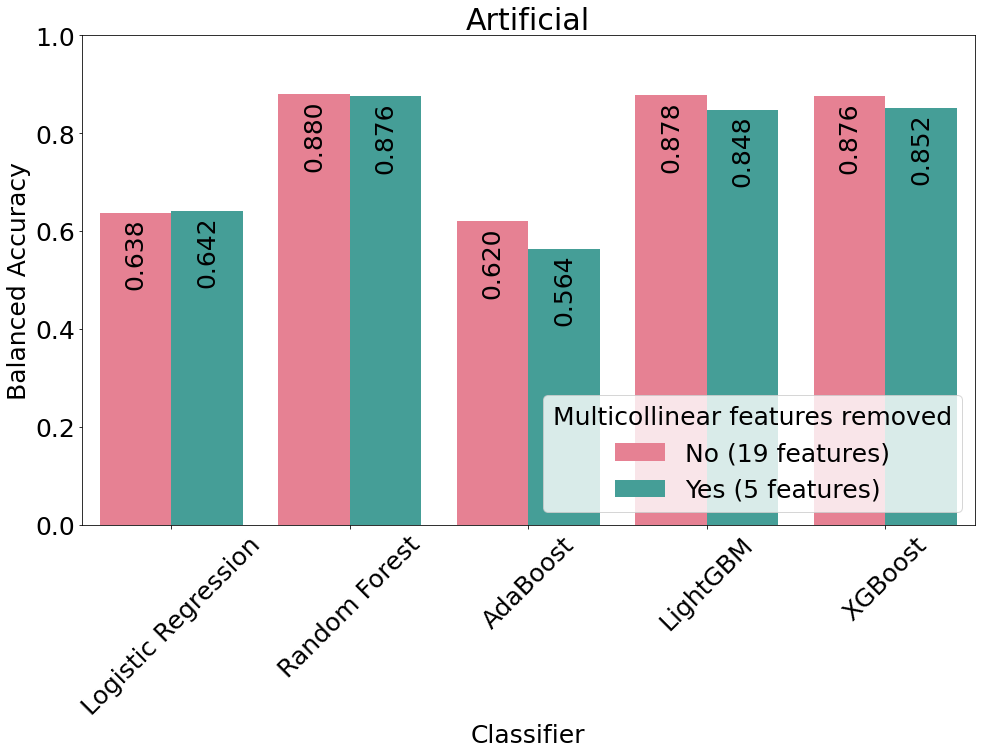

In [28]:
bars = sns.barplot(x='Classifier', y='BA score', hue='VIF', data=res_boruta_all,palette=sns.color_palette("husl", 2))
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()-0.1), ha='center', va='center', xytext=(0, 8), rotation=90,
                   textcoords='offset points')
plt.ylim(0, 1)
plt.legend(loc=4, title='Multicollinear features removed')
plt.xlabel('Classifier')
plt.ylabel('Balanced Accuracy')
plt.title('Artificial')#\nClassifiers performance after Boruta feature selection')
plt.xticks(rotation=45)
plt.show()

In [29]:
X_art_train_scaled_boruta_multiple_vif.columns

Int64Index([64, 281, 378, 451, 453], dtype='int64')